# K Means Algorithm

The K-Means algorithm is probably the most prominent unsupervised clustering algorithm.

K-Means clustering aims to partition N feature vectors into k clusters, where each vector belongs to the cluster with the nearest mean. This can be seen as a Voroni Teselation of the feature space.

Even thought this is a NP-Hard problem, several greedy algorithms have been developed in order to obtain locally optimal solutions, that highly depend on the initialization. The most famous ones are the nearest-mean and the nearest-centroid algorithm. Both methods are tighly closed to the K-Nearest-Neighbors algorithm.


# Nearest mean method

The __nearest mean method__ consists on the following steps:

> 1. Compute K Means(randomly or best guessing)

> 2. Assign each point to the closest that hast the closest mean

> 3. Compute the mean of each clustering by averaging all feature vectors that belong to the given cluster.

> 4. Reassign feaure vectores to the cluster with the closest mean

> 5. Check for convergence or for end of iterations. Otherwise, go back to point 3.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.spatial.distance as distance
from sklearn.datasets.samples_generator import make_blobs

import k_means as k_means

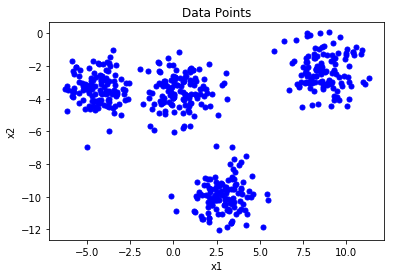

In [2]:
# obtaining and displaying our data
original_data, _ = make_blobs(500, 2, centers=4, cluster_std=1)

ax = plt.gca()
im, = ax.plot( original_data[:,0], original_data[:,1], "bo", markersize=5)
ax.set_title("Data Points")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.show()

In [3]:
def display_clusters(data, clusters, means=[], ax=None, title="", xlabel="", ylabel=""): 
    
    k = np.max(clusters)+1
    
    colors = {
        "0":"bo",
        "1":"go",
        "2":"co",
        "3":"mo",
        "4":"yo",
        "5":"ko"
    }
    
    if(ax==None):
        fig,ax = plt.subplots(1,1)
        
    # displaying each cluster with a different color
    for i in range(k):
        idx = np.where(clusters==i)[0]
        color = colors[str(i)]
        ax.plot(data[idx,0],data[idx,1], color, label=f"Cluster {i+1}")
      
    # displaying cluster centers if given
    if( len(means)>0 ):
        ax.plot(means[:,0],means[:,1], "ro", label="Cluster Centers" )
            
    ax.legend(loc="best")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
        
    return
        

In [4]:
def k_means_iteration(data, clusters, k=4):
    
    # computing the new means
    means = np.empty((0,2))
    for i in range(k):
        idx = np.where(clusters==i)[0]
        mean = np.mean(data[idx,:], axis=0)
        if(np.isnan(mean[0])):
            continue
        means = np.vstack((means, mean))
    
    # reassigning points to the clusters
    clusters = np.array([],dtype=np.int)
    for point in data:
        distances = np.linalg.norm(means-point, ord=2, axis=1)
        cluster = np.argmin(distances)
        clusters = np.append(clusters, cluster)
        
    return clusters, means
    
    
def k_means_clustering(data, k=4, iters=4):
    
    fig, ax = plt.subplots(2,2)
    fig.set_size_inches(12, 10)
    
    # drawing random initial centers
    mean = np.mean(data)
    std = np.std(data)/2
    means = std*np.random.randn(k,2)+mean
    
    # reassigning points to the clusters
    previous_clusters = np.empty(0)
    clusters = np.array([],dtype=np.int)
    for point in data:
        distances = np.linalg.norm(means-point, ord=2, axis=1)
        cluster = np.argmin(distances)
        clusters = np.append(clusters, cluster)

    # computing iterations
    for i in range(iters):
        clusters, means = k_means_iteration(data=data, clusters=clusters, k=k)
        
        row = i//2
        col = i%2
        display_clusters(data=data, clusters=clusters, means=means, ax=ax[row,col]) 
        
        # checking for convergence
        if( len(previous_clusters) != 0 ):
            if( np.array_equal(previous_clusters, clusters) ):
                break
            
        previous_clusters = clusters

    return clusters, means

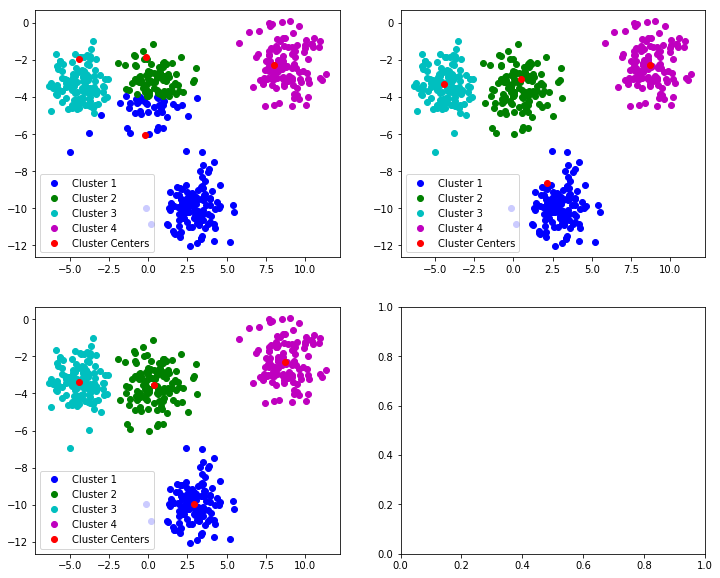

In [13]:
clusters,_ = k_means_clustering( original_data, k=4, iters=4)

# Model Selection Problem

A sensitive choice for K is vital for the correct convergence of the algorithm. The clusters for K-1 need not be a subset of the clusters for K, and the same happens for K+1. 

This is the model selection problem in the K-Means algorithm, which is ilustrated in the next cells. We can clearly see how the algorithm fails for a wrong number of clusters.

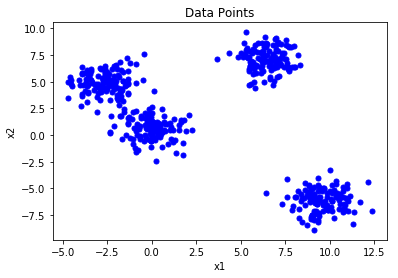

In [14]:
# obtaining and displaying our data
original_data, _ = make_blobs(500, 2, centers=4, cluster_std=1)

ax = plt.gca()
im, = ax.plot( original_data[:,0], original_data[:,1], "bo", markersize=5)
ax.set_title("Data Points")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.show()

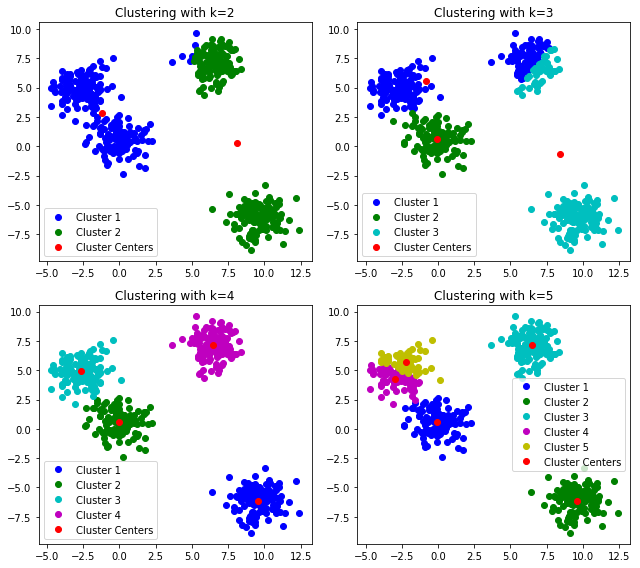

In [15]:
clusters_2, centers_2 = k_means.k_means_clustering(original_data, k=2, iters=10)
clusters_3, centers_3 = k_means.k_means_clustering(original_data, k=3, iters=10)
clusters_4, centers_4 = k_means.k_means_clustering(original_data, k=4, iters=10)
clusters_5, centers_5 = k_means.k_means_clustering(original_data, k=5, iters=10)

fig, ax = plt.subplots(2,2)
fig.set_size_inches(9,8)

display_clusters(original_data, clusters_2, means=centers_2, ax=ax[0,0], title="Clustering with k=2")
display_clusters(original_data, clusters_3, means=centers_3, ax=ax[0,1], title="Clustering with k=3")
display_clusters(original_data, clusters_4, means=centers_4, ax=ax[1,0], title="Clustering with k=4")
display_clusters(original_data, clusters_5, means=centers_5, ax=ax[1,1], title="Clustering with k=5")

plt.tight_layout()
plt.show()

# Gap Statistics

Gap Statistics is a method proposed by Tibsherani to obtain the optimal K to perform the K-Means clustering algortihm. The idea is to related the Within-Cluster-Distance ($W(C)$) of the distribution with the $W(C)$ of a synthetic distribution ($W_s(C)$), typically a uniform one.

The K-Means produces a Voroni-Tesselation of the feature space for the synthetic distribution, producing a smooth Distance Curve. This curve looses its smoothness when computed for the real data distribution.

__Algorithm__:
 > 1: Repeat the synthetic sampling B times (Mpontecarlo Experiment)
 
 > 2: Calculate W(C) for each K for each distribution <br>
 
 > 3: Compute the mean and standard deviation of W(C) for each K <br>
 
 > 4: Compute the gaps: <br>
             >> $G(K) = E\{log(W_s(K))\} - log(W(K))$ <br>
 
 > 5: Find the optimal K as: <br>
             >> $K^* = argmin\{ K | G(K)>G(K+1)-S_{k+1}\}$


In [16]:
# method that computes the within cluster distance for the clusters
def within_cluster_distance(data, labels):
    W = 0
    N = int(np.max(labels)+1)
    for i in range(N):
        clusterData = data[np.where(labels==i)]
        W += np.sum(
            np.square(distance.cdist(clusterData, clusterData, 'euclidean'))
            )

    return W
            

# Method that creates a synthetic uniform distribution
def createUniformSamples( numSamples, mean=0, variance=1 ):

    offset = variance/2
    uniform_samples = variance*np.random.rand(numSamples,2)-offset+mean
    uniform_labels = np.ones( numSamples, dtype=np.int )
            
    return uniform_samples, uniform_labels
            

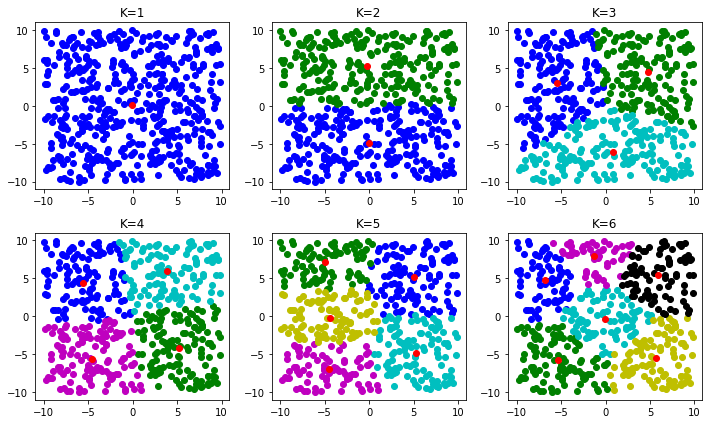

In [17]:
# creating a synthetic distribution
N = 500
uniform_samples, uniform_labels = createUniformSamples(numSamples=N, variance=20)

synthetic_distances = []
max_K = 7

fig,ax = plt.subplots(2,3)
fig.set_size_inches(10,6)

# performing the K-means algorithm in the synthetic distribution
for i in range(1,max_K):
    clusters, means = k_means.k_means_clustering( uniform_samples, k=i, iters=10)
    cluster_distance = within_cluster_distance(uniform_samples, clusters)
    synthetic_distances.append(cluster_distance)
    
    row = (i-1)//3
    col = (i-1)%3
    k_means.display_clusters(data=uniform_samples, clusters=clusters, means= means,
                                ax=ax[row,col], title=f"K={i}", legend=False)
    
    
plt.tight_layout()
plt.show()

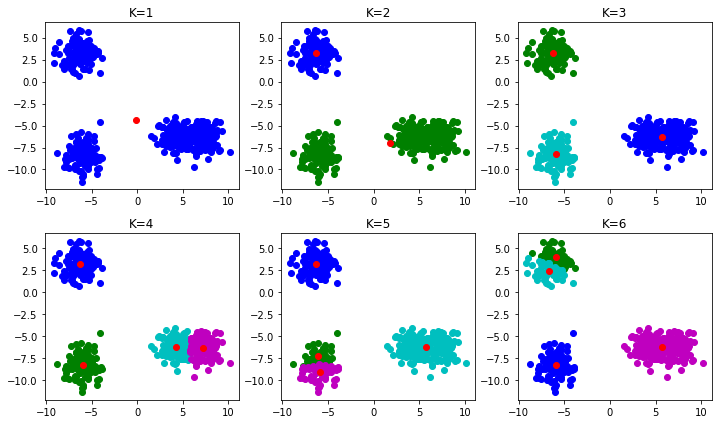

In [18]:
# computing a real distribution
original_data, _ = make_blobs(500, 2, centers=4, cluster_std=1)

real_distances = []
max_K = 7

fig,ax = plt.subplots(2,3)
fig.set_size_inches(10,6)

# performing the K-means algorithm in the real distribution
for i in range(1,max_K):
    clusters, means = k_means.k_means_clustering( original_data, k=i, iters=10)
    cluster_distance = within_cluster_distance(original_data, clusters)
    real_distances.append(cluster_distance)
    
    row = (i-1)//3
    col = (i-1)%3
    k_means.display_clusters(data=original_data, clusters=clusters, means= means,
                                ax=ax[row,col], title=f"K={i}", legend=False)
    
    
plt.tight_layout()
plt.show()

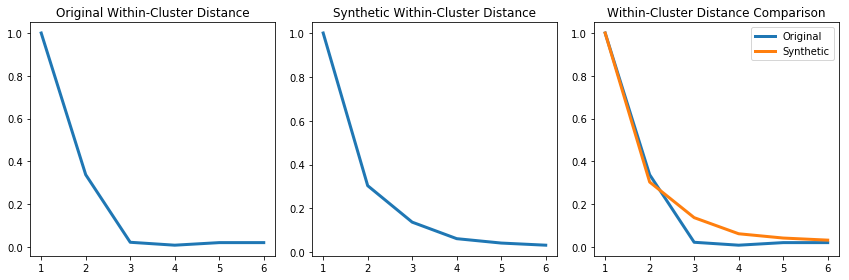

In [19]:
# computing the within-cluster-distance curves
fig,ax = plt.subplots(1,3)
fig.set_size_inches(12,4)

K = np.arange(1,max_K)
real_distances = real_distances/np.max(real_distances)
synthetic_distances = synthetic_distances/np.max(synthetic_distances)

ax[0].plot(K, real_distances, linewidth=3)
ax[0].set_title("Original Within-Cluster Distance")

ax[1].plot(K, synthetic_distances, linewidth=3)
ax[1].set_title("Synthetic Within-Cluster Distance")

ax[2].plot(K, real_distances, linewidth=3, label="Original")
ax[2].plot(K, synthetic_distances, linewidth=3, label="Synthetic")
ax[2].set_title("Within-Cluster Distance Comparison")
ax[2].legend()

plt.tight_layout()
plt.show()

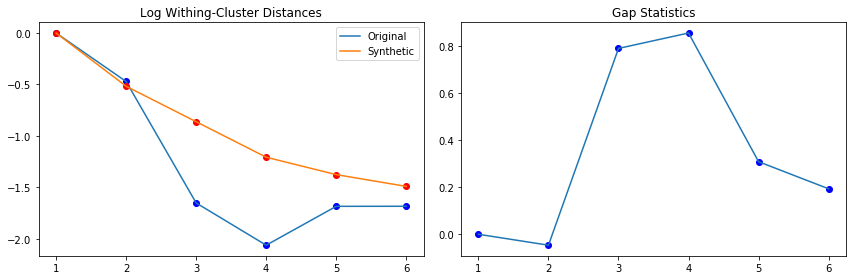

In [20]:
real_distances_log = np.log10(real_distances)
synthetic_distances_log = np.log10(synthetic_distances)
gap = synthetic_distances_log - real_distances_log

fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,4)

K = np.arange(1,max_K)
ax[0].plot(K, real_distances_log, "bo")
ax[0].plot(K, real_distances_log, label="Original")
ax[0].plot(K, synthetic_distances_log, "ro")
ax[0].plot(K, synthetic_distances_log, label="Synthetic")
ax[0].set_title("Log Withing-Cluster Distances")
ax[0].legend()

ax[1].plot(K, gap, "bo")
ax[1].plot(K, gap)
ax[1].set_title("Gap Statistics")

plt.tight_layout()
plt.show()

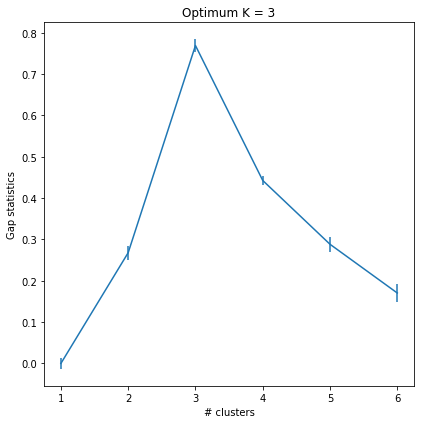

In [21]:
optimum_k = k_means.compute_gap_statistics( original_data, display=True )